In [1]:
%pylab inline

import astropy
import calendar
from astropy.time import Time,TimezoneInfo,TimeDelta
from astropy import units as u
from astropy import coordinates as co
import pandas as pd
import numpy as np
import pylab as pl
from astroplan import Observer, FixedTarget, is_observable, is_always_observable, months_observable, observability_table
from astroplan import (AltitudeConstraint, AirmassConstraint,
                       AtNightConstraint)



Populating the interactive namespace from numpy and matplotlib


In [2]:
nnights = 365
max_obs = 100
target = FixedTarget.from_name('HD155060')
t = Time('2021-02-2') + arange(nnights) * u.day # UT date
df = pd.DataFrame(dict(utdate=t.to_value('iso','date')))
keck = Observer.at_site("Keck", timezone="US/Hawaii")
sunset = keck.sun_set_time(t,horizon=-12*u.deg,which='next')
sunrise =  keck.sun_rise_time(t,horizon=-12*u.deg, which='next')
moonrise = keck.moon_rise_time(t,horizon=0*u.deg, which='next')
nightlength = (sunrise - sunset)
constraints = [AltitudeConstraint(20*u.deg, 85*u.deg)]

In [3]:
savecols = 'utdate quarter start stop start_jd stop_jd kpfcc dark'.split()

In [4]:
df2 = []
for i in range(1,5):
    df = pd.DataFrame(dict(utdate=t.to_value('iso','date')))
    df = pd.DataFrame(dict(utdate=Time(t.to_datetime(timezone=keck.timezone)).to_value('iso','date')))
    df['quarter'] = i
    start = sunset + (i-1) / 4.0 * nightlength
    stop = sunset +  i / 4.0 * nightlength
    df['nightlength'] = nightlength.value
    df['start_jd'] =  start.jd
    df['stop_jd'] = stop.jd
    df['start'] = pd.Series(start.to_value('iso','date_hm')).str.slice(start=11,stop=16)
    df['stop'] = pd.Series(stop.to_value('iso','date_hm')).str.slice(start=11,stop=16)
    df['month'] = start.ymdhms['month']
    df['moon_alt_start'] = keck.moon_altaz(start).alt.deg
    df['moon_alt_stop'] = keck.moon_altaz(stop).alt.deg
    df2.append(df)

df = pd.concat(df2)
df = df.sort_values(by=['start_jd'])
df = df.reset_index(drop=True)
df['kpfcc'] = False
df['dark'] = (df.moon_alt_start < 0) & (df.moon_alt_stop < 0)

dark_early = df[df.quarter.isin([1,2])].groupby('utdate').filter(lambda x: x['dark'].sum()==2)
dark_late = df[df.quarter.isin([3,4])].groupby('utdate').filter(lambda x: x['dark'].sum()==2)
dark_all = df.groupby('utdate').filter(lambda x: x['dark'].sum()==4)


dfrem = df.copy()
rs = 0 
nstart_quarters = len(df)
nkpfcc_quarters = 365 
ndark_quarters = 365 # remove this many quarters for darktime


dfrem = dfrem.drop(dark_all.index,errors='ignore')
dfrem = dfrem.drop(dark_early.index,errors='ignore')
dfrem = dfrem.drop(dark_late.index,errors='ignore')

print("{}/{} quarters remain after dropping dark all, early, late".format(len(dfrem),nstart_quarters))

# schedule 1/8 of nights are first half

for i in range(4):
    if i==0:
        # schedule 1/8 of nights as Q1+Q2
        nnights_select = int(0.125 * nkpfcc_quarters)
        dates = dfrem.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & (df.quarter.isin([1,2])),'kpfcc'] = True

    if i==1:
        # schedule 1/8 of nights as Q3+Q4
        nnights_select = int(0.125 * nkpfcc_quarters)
        dates = dfrem.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & df.quarter.isin([3,4]),'kpfcc'] = True

    if i==2:
        # schedule 1/5 of nights as Q1 
        nnights_select = int(0.25 * nkpfcc_quarters)
        dates = dfrem.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & df.quarter.isin([1]),'kpfcc'] = True

    if i==3:
        # schedule 1/4 of nights as Q4
        nnights_select = int(0.25 * nkpfcc_quarters)
        dates = dfrem.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & df.quarter.isin([4]),'kpfcc'] = True

    dfrem = dfrem[~dfrem.utdate.isin(dates)]
    

print("{}/{} quarters are KPF-CC".format(df.kpfcc.sum(),nstart_quarters))
print("{}/{} nights KPF-CC onsky".format((df.groupby('utdate')['kpfcc'].sum()>0).sum(),nnights))

# df[savecols].to_csv('kpfcc_schedule_v2.csv')

1012/1460 quarters remain after dropping dark all, early, late
362/1460 quarters are KPF-CC
272/365 nights KPF-CC onsky


/Users/bfulton/anaconda3/lib/python3.8/site-packages/xarray/plot/plot.py:1451: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(x.dtype, str)
/Users/bfulton/anaconda3/lib/python3.8/site-packages/xarray/plot/plot.py:1466: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(y.dtype, str)


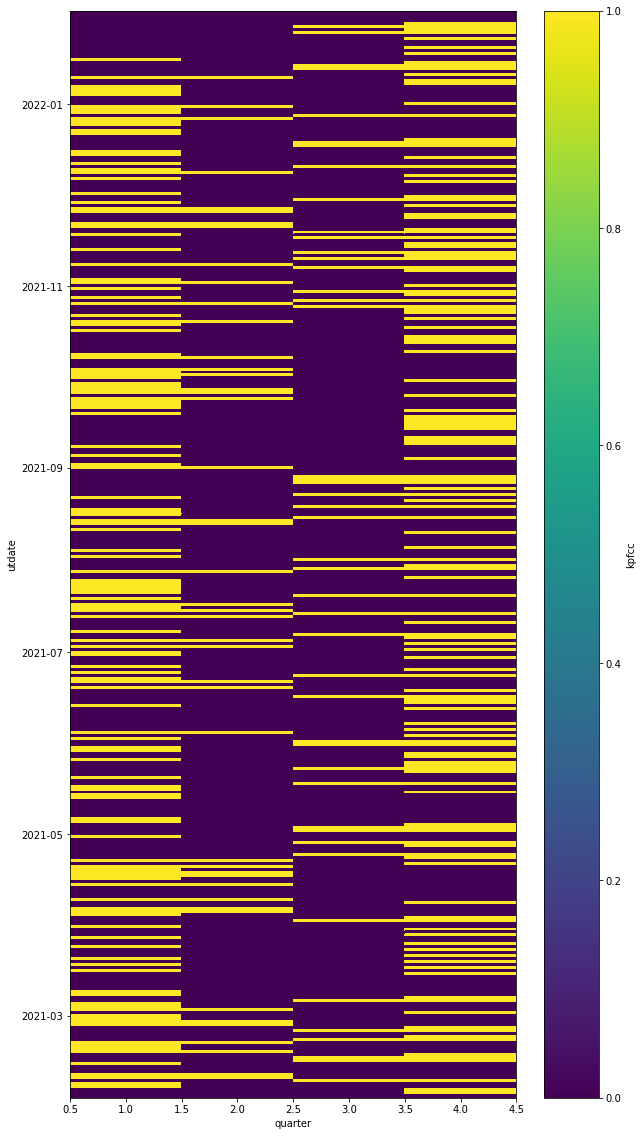

In [5]:
da = df.groupby(['utdate','quarter'])['kpfcc'].first().to_xarray()
da.coords['utdate'] = Time(list(array(da.utdate))).datetime
da.sortby(da.utdate,ascending=False).plot.pcolormesh(figsize=(10,20))

In [7]:
timestamps = []
dates_observed = []
f = open('timestamps_C.csv', 'w')
date_groups = df[df['kpfcc']].groupby('utdate', as_index=False)
for grp in date_groups:
    num = len(grp[1])
    block = grp[1].sample(1)
    date = block['utdate'].values[0]
    print(date)
    if date not in dates_observed:
        obs = Time(np.random.uniform(block.start_jd, block.stop_jd), format='jd')[0]
        if keck.target_is_up(obs, target):
            print(obs, num)
            timestamps.append(obs)
            dates_observed.append(date)
            print(obs, file=f)
        if len(timestamps) >= max_obs:
            break


f.close()
    

2021-02-03
2459249.142174821 1
2021-02-04
2459250.1130509274 1
2021-02-05
2021-02-06
2021-02-07
2021-02-08
2021-02-09
2021-02-13
2021-02-14
2459260.1432575947 2
2021-02-15
2459260.9777257484 2
2021-02-16
2459262.0590903535 1
2021-02-17
2021-02-18
2021-02-19
2021-02-20
2021-02-21
2459267.110239887 2
2021-02-22
2459268.0714157666 1
2021-02-24
2459270.0277451403 2
2021-02-25
2459271.067927719 1
2021-02-26
2021-02-27
2021-02-28
2021-03-01
2021-03-02
2459276.092460134 1
2021-03-03
2021-03-04
2021-03-05
2021-03-06
2459279.967077258 2
2021-03-07
2459281.156050256 1
2021-03-08
2021-03-09
2021-03-15
2459289.074912749 1
2021-03-16
2021-03-17
2459291.086409956 1
2021-03-18
2021-03-19
2459293.089458895 1
2021-03-20
2021-03-21
2459295.122170787 1
2021-03-23
2459297.0673696296 1
2021-03-24
2021-03-25
2459299.1397910593 1
2021-03-27
2021-03-28
2459302.0442536017 1
2021-03-30
2459304.046138459 1
2021-03-31
2021-04-02
2459306.98645858 2
2021-04-03
2459308.0745502794 1
2021-04-04
2021-04-05
2459309.8827

In [18]:
timestamps = []
f = open('timestamps_A.csv', 'w')
date_groups = df[df['kpfcc']].query('3 <= month <= 10')\
    .sample(16)\
        .sort_values(by='utdate')\
            .groupby('utdate', as_index=False)
i = 0
while len(timestamps) < max_obs:
    for grp in date_groups:
        num = len(grp[1])
        block = grp[1].sample(1)
        date = block['utdate'].values[0] + timedelta(years=i)
        start = "{:s} {:s}".format(date, block.start.values[0])
        end = "{:s} {:s}".format(date, block.stop.values[0])
        range = Time([start, end])
        can_obs = is_observable(constraints, keck, target, range)[0]
        tab = observability_table(constraints, keck, [target], range, time_grid_resolution=60*u.second)
        obs = Time(np.random.uniform(block.start_jd, block.stop_jd), format='jd')[0]
        frac = tab['fraction of time observable']
        hours_observable = ((range[1] - range[0]) * frac) * 24
        hours_observable = hours_observable[0]
        print(start, end, hours_observable)
        if can_obs and hours_observable >= 1:
            # print(obs, num, can_obs, hours_observable)
            timestamps.append(obs)
            print(obs, file=f)
        if len(timestamps) >= max_obs:
            break
        i+=1

f.close()

2021-03-05 05:15 2021-03-05 07:54 0.0
2021-03-06 13:11 2021-03-06 15:49 2.633333333333332
2021-03-16 05:19 2021-03-16 07:54 0.0
2021-03-17 13:05 2021-03-17 15:40 2.583333333333335
2021-03-21 13:03 2021-03-21 15:37 2.566666666666668
2021-03-27 05:22 2021-03-27 07:54 0.0
2021-04-03 12:55 2021-04-03 15:25 2.5000000000000018
2021-04-06 07:54 2021-04-06 10:24 1.2500000000000009
2021-04-14 07:55 2021-04-14 10:22 1.2249999999999996
2021-04-16 05:29 2021-04-16 07:55 0.0
2021-04-17 05:29 2021-04-17 07:55 0.0
2021-04-19 05:30 2021-04-19 07:55 0.0
2021-04-22 05:31 2021-04-22 07:55 0.0
2021-05-03 12:39 2021-05-03 15:01 2.3666666666666663
2021-05-17 05:43 2021-05-17 08:00 1.141666666666666
2021-05-25 12:34 2021-05-25 14:50 2.2666666666666666
2021-05-26 05:47 2021-05-26 08:03 1.1333333333333326
2021-05-28 12:34 2021-05-28 14:49 2.25
2021-06-03 12:34 2021-06-03 14:48 2.2333333333333334
2021-06-04 05:51 2021-06-04 08:05 2.233333333333332
2021-06-14 12:35 2021-06-14 14:49 2.2333333333333334
2021-06-19 

<ipython-input-35-262adb8d8afd>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([x-2450000 for x in ax.get_xticks()])
<ipython-input-35-262adb8d8afd>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([x-2450000 for x in ax.get_xticks()])
<ipython-input-35-262adb8d8afd>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([x-2450000 for x in ax.get_xticks()])
<ipython-input-35-262adb8d8afd>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axyrs.xaxis.set_ticklabels([calendar.month_abbr[int(x)] for x in axyrs.get_xticks()])


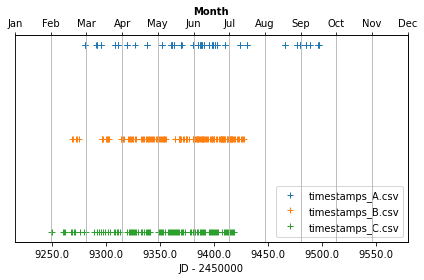

In [35]:
def jd2date(t):
    return Time(t, format='jd').datetime

def date2jd(t):
    try:
        time = Time(t, format='datetime').jd
    except:
        time = Time(2455565, format='jd')
        pass
    return time

i = 0
for fname in ['timestamps_A.csv', 'timestamps_B.csv', 'timestamps_C.csv']:
# for fname in ['timestamps_A.csv']:
    times = pd.read_csv(fname, header=None)
    dts = [jd2date(t[0]) for t in times.values]
    times = [date2jd(t) for t in dts]
    pl.plot(times, np.zeros_like(times)+i, '+', label=fname)
    ax = pl.gca()
    ax.set_xlabel('JD - 2450000')
    ax.xaxis.set_ticklabels([x-2450000 for x in ax.get_xticks()])
    ax.yaxis.set_ticks([])
    ax.set_xlim(Time('2021-01-01', format='iso').jd, Time('2021-12-31', format='iso').jd)
    i -= 1


axyrs = ax.twiny()
xl = np.array(list(ax.get_xlim()))
pl.locator_params(axis='x', nbins=12)
start = Time(xl[0], format='jd', scale='utc').ymdhms['month']
end = Time(xl[1], format='jd', scale='utc').ymdhms['month']
axyrs.set_xlim(start, end)
axyrs.xaxis.set_ticklabels([calendar.month_abbr[int(x)] for x in axyrs.get_xticks()])
axyrs.set_xlabel('Month', fontweight='bold')

pl.tight_layout()
pl.grid(True)
ax.legend()
pl.show()


In [27]:
start = "{:s} {:s}".format(block.utdate.values[0], block.start.values[0])
end = "{:s} {:s}".format(block.utdate.values[0], block.stop.values[0])
time_range = Time([start, end])
print(is_observable(constraints, keck, target, time_range))
print(is_always_observable(constraints, keck, target, time_range))
print(observability_table(constraints, keck, [target], time_range))

[ True]
[False]
target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
   HD155060            True             False                         0.5


In [34]:
axyrs.get_xticks([])

<ipython-input-34-960176e4d6cc>:1: MatplotlibDeprecationWarning: Passing the minor parameter of get_ticklocs() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  axyrs.get_xticks([])


array([-0.06, -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,
        0.03,  0.04,  0.05,  0.06])